In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 27 10:42:50 2020

@author: Haoran6
"""

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class DBS_lstm(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_stacks):
        super(DBS_lstm, self).__init__()
        self.lstm_layer = nn.LSTM(input_dim, hidden_dim, num_stacks).double()
        self.hidden2dbs = nn.Linear(hidden_dim, 6890*3, bias=False).double()

    def forward(self, pose_beta_seq):
        num_frames = pose_beta_seq.shape[0]
        lstm_out, _ = self.lstm_layer(pose_beta_seq.view(num_frames, 1, -1))
        dbs = self.hidden2dbs(lstm_out).view(num_frames, 6890, 3)
        return dbs

class DBS_gru(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_stacks):
        super(DBS_gru, self).__init__()
        self.gru_layer = nn.GRU(input_dim, hidden_dim, num_stacks).double()
        self.hidden2dbs = nn.Linear(hidden_dim, 6890*3, bias=False).double()

    def forward(self, pose_beta_seq):
        num_frames = pose_beta_seq.shape[0]
        gru_out, _ = self.gru_layer(pose_beta_seq.view(num_frames, 1, -1))
        dbs = self.hidden2dbs(gru_out).view(num_frames, 6890, 3)
        return dbs

class DBS_tcn(nn.Module):
    
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.1):
        super(DBS_tcn, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout).double()
        self.hidden2dbs = nn.Linear(num_channels[-1], output_size, bias=False).double()

    def forward(self, pose_beta_seq):
        """ Input ought to have dimension (N, C_in, L_in), where L_in is the seq_len """
        num_frames = pose_beta_seq.shape[0]
        tcn_out = self.tcn(pose_beta_seq.transpose(0, 1).view(1,-1,num_frames)).transpose(1, 2).squeeze()
        dbs = self.hidden2dbs(tcn_out).view(num_frames, 6890, 3)
        return dbs

In [3]:
import numpy as np
import pickle
import torch
from torch.nn import Module
import os
from time import time

class DBSModel(Module):
  def __init__(self, device=None, model_path='./body_models/smpl/male/model.pkl',\
               dbs_type='tcn',num_c=[512,768,1024],hd=1024,num_sk=5,dbs_model_path=None):
    
    super(DBSModel, self).__init__()
    with open(model_path, 'rb') as f:
      params = pickle.load(f)
    self.J_regressor = torch.from_numpy(
      np.array(params['J_regressor'].todense())
    ).type(torch.float64)
    if 'joint_regressor' in params.keys():
      self.joint_regressor = torch.from_numpy(
        np.array(params['joint_regressor'].T.todense())
      ).type(torch.float64)
    else:
      self.joint_regressor = torch.from_numpy(
        np.array(params['J_regressor'].todense())
      ).type(torch.float64)
    self.weights = torch.from_numpy(params['weights']).type(torch.float64)
    self.posedirs = torch.from_numpy(params['posedirs']).type(torch.float64)
    self.v_template = torch.from_numpy(params['v_template']).type(torch.float64)
    self.shapedirs = torch.from_numpy(params['shapedirs']).type(torch.float64)
    self.kintree_table = params['kintree_table']
    self.faces = params['f']
    self.device = device if device is not None else torch.device('cpu')
    for name in ['J_regressor', 'joint_regressor', 'weights', 'posedirs', 'v_template', 'shapedirs']:
      _tensor = getattr(self, name)
      # print('Tensor {} shape: '.format(name), _tensor.shape)
      setattr(self, name, _tensor.to(device))
    
    if dbs_type == 'lstm':
        dbs_layer = DBS_lstm(input_dim=289,hidden_dim=hd,num_stacks=num_sk)
    elif dbs_type == 'gru':
        dbs_layer = DBS_gru(input_dim=289,hidden_dim=hd,num_stacks=num_sk)
    elif dbs_type == 'tcn':
        dbs_layer = DBS_tcn(input_size=289, output_size=6890*3, num_channels=num_c)
    else:
        raise AssertionError('dbs_type is wrong')
    
    self.dbs_layer = dbs_layer.to(device)
    
    if dbs_model_path is not None:
        self.load_state_dict(torch.load(dbs_model_path))
        self.eval()
    

  @staticmethod
  def rodrigues(r):
    """
    Rodrigues' rotation formula that turns axis-angle tensor into rotation
    matrix in a batch-ed manner.

    Parameter:
    ----------
    r: Axis-angle rotation tensor of shape [batch_size * angle_num, 1, 3].

    Return:
    -------
    Rotation matrix of shape [batch_size * angle_num, 3, 3].

    """
    eps = r.clone().normal_(std=1e-8)
    theta = torch.norm(r + eps, dim=(1, 2), keepdim=True)  # dim cannot be tuple
    theta_dim = theta.shape[0]
    r_hat = r / theta
    cos = torch.cos(theta)
    z_stick = torch.zeros(theta_dim, dtype=torch.float64).to(r.device)
    m = torch.stack(
      (z_stick, -r_hat[:, 0, 2], r_hat[:, 0, 1], r_hat[:, 0, 2], z_stick,
       -r_hat[:, 0, 0], -r_hat[:, 0, 1], r_hat[:, 0, 0], z_stick), dim=1)
    m = torch.reshape(m, (-1, 3, 3))
    i_cube = (torch.eye(3, dtype=torch.float64).unsqueeze(dim=0) \
             + torch.zeros((theta_dim, 3, 3), dtype=torch.float64)).to(r.device)
    A = r_hat.permute(0, 2, 1)
    dot = torch.matmul(A, r_hat)
    R = cos * i_cube + (1 - cos) * dot + torch.sin(theta) * m
    return R

  @staticmethod
  def with_zeros(x):
    """
    Append a [0, 0, 0, 1] tensor to a [3, 4] tensor.

    Parameter:
    ---------
    x: Tensor to be appended.

    Return:
    ------
    Tensor after appending of shape [4,4]

    """
    ones = torch.tensor(
      [[[0.0, 0.0, 0.0, 1.0]]], dtype=torch.float64
    ).expand(x.shape[0],-1,-1).to(x.device)
    ret = torch.cat((x, ones), dim=1)
    return ret

  @staticmethod
  def pack(x):
    """
    Append zero tensors of shape [4, 3] to a batch of [4, 1] shape tensor.

    Parameter:
    ----------
    x: A tensor of shape [batch_size, 4, 1]

    Return:
    ------
    A tensor of shape [batch_size, 4, 4] after appending.

    """
    zeros43 = torch.zeros(
      (x.shape[0], x.shape[1], 4, 3), dtype=torch.float64).to(x.device)
    ret = torch.cat((zeros43, x), dim=3)
    return ret

  def write_obj(self, verts, file_name):
    with open(file_name, 'w') as fp:
      for v in verts:
        fp.write('v %f %f %f\n' % (v[0], v[1], v[2]))

      for f in self.faces + 1:
        fp.write('f %d %d %d\n' % (f[0], f[1], f[2]))

  def forward(self, betas, pose, trans, simplify=False):
    
    """
          Construct a compute graph that takes in parameters and outputs a tensor as
          model vertices. Face indices are also returned as a numpy ndarray.
          
          20190128: Add batch support.

          Parameters:
          ---------
          pose: Also known as 'theta', an [N, 24, 3] tensor indicating child joint rotation
          relative to parent joint. For root joint it's global orientation.
          Represented in a axis-angle format.

          betas: Parameter for model shape. A tensor of shape [N, 10] as coefficients of
          PCA components. Only 10 components were released by SMPL author.

          trans: Global translation tensor of shape [N, 3].

          Return:
          ------
          A 3-D tensor of [N * 6890 * 3] for vertices,
          and the corresponding [N * 19 * 3] joint positions.

    """
    batch_num = betas.shape[0]
    id_to_col = {self.kintree_table[1, i]: i
                 for i in range(self.kintree_table.shape[1])}
    parent = {
      i: id_to_col[self.kintree_table[0, i]]
      for i in range(1, self.kintree_table.shape[1])
    }
    v_shaped = torch.tensordot(betas, self.shapedirs, dims=([1], [2])) + self.v_template
    J = torch.matmul(self.J_regressor, v_shaped)
    R_cube_big = self.rodrigues(pose.view(-1, 1, 3)).reshape(batch_num, -1, 3, 3)

    if simplify:
      v_posed = v_shaped
    else:
      R_cube = R_cube_big[:, 1:, :, :]
      I_cube = (torch.eye(3, dtype=torch.float64).unsqueeze(dim=0) + \
        torch.zeros((batch_num, R_cube.shape[1], 3, 3), dtype=torch.float64)).to(self.device)
      lrotmin = (R_cube - I_cube).reshape(batch_num, -1, 1).squeeze(dim=2)
      v_posed = v_shaped + torch.tensordot(lrotmin, self.posedirs, dims=([1], [2]))
      # print(lrotmin.shape, self.posedirs.shape)
    
    R_pose = R_cube.reshape(batch_num, -1, 1).squeeze(dim=2)
    pose_beta_seq = torch.cat((R_pose, pose, betas),1)
    dbs = self.dbs_layer(pose_beta_seq)
    v_posed += dbs
    
    results = []
    results.append(
      self.with_zeros(torch.cat((R_cube_big[:, 0], torch.reshape(J[:, 0, :], (-1, 3, 1))), dim=2))
    )
    for i in range(1, self.kintree_table.shape[1]):
      results.append(
        torch.matmul(
          results[parent[i]],
          self.with_zeros(
            torch.cat(
              (R_cube_big[:, i], torch.reshape(J[:, i, :] - J[:, parent[i], :], (-1, 3, 1))),
              dim=2
            )
          )
        )
      )
    
    stacked = torch.stack(results, dim=1)
    results = stacked - \
      self.pack(
        torch.matmul(
          stacked,
          torch.reshape(
            torch.cat((J, torch.zeros((batch_num, 24, 1), dtype=torch.float64).to(self.device)), dim=2),
            (batch_num, 24, 4, 1)
          )
        )
      )
    # Restart from here
    T = torch.tensordot(results, self.weights, dims=([1], [1])).permute(0, 3, 1, 2)
    rest_shape_h = torch.cat(
      (v_posed, torch.ones((batch_num, v_posed.shape[1], 1), dtype=torch.float64).to(self.device)), dim=2
    )
    v = torch.matmul(T, torch.reshape(rest_shape_h, (batch_num, -1, 4, 1)))
    v = torch.reshape(v, (batch_num, -1, 4))[:, :, :3]
    result = v + torch.reshape(trans, (batch_num, 1, 3))
    # estimate 3D joint locations
    # print(result.shape)
    # print(self.joint_regressor.shape)
    # joints = torch.tensordot(result, self.joint_regressor, dims=([1], [0])).transpose(1, 2)
        
    # pose_beta_seq = torch.cat((pose, betas),1)
    # dbs = self.dbs_layer(pose_beta_seq)
    # result += dbs
    
    return result


def test_gpu(gpu_id=[0]):
  # if len(gpu_id) > 0 and torch.cuda.is_available():
  #   os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id[0])
  #   device = torch.device('cuda')
  # else:
  #   device = torch.device('cpu')
  #print(device)
  
  device = torch.device('cpu')
  num_frames = 10
  
  pose_size = 72
  beta_size = 10

  np.random.seed(9608)
  model = DBSModel(device=device, dbs_type='lstm')
  for i in range(10):
      pose = torch.from_numpy((np.random.rand(num_frames, pose_size) - 0.5) * 0.4)\
              .type(torch.float64).to(device)
      betas = torch.from_numpy((np.random.rand(num_frames, beta_size) - 0.5) * 0.06) \
              .type(torch.float64).to(device)
      trans = torch.from_numpy(np.zeros((num_frames, 3))).type(torch.float64).to(device)
      
      s = time()
      result = model(betas, pose, trans)
      print(time() - s)
      
   # outmesh_path = './dmpl_batch_obj/dmpl_torch_{}.obj'
   # for i in range(result.shape[0]):
   #      model.write_obj(result[i], outmesh_path.format(i))



In [4]:
bpts2dbs_data = torch.load("/content/drive/My Drive/male_bpts2dbs.pt")
training_set = bpts2dbs_data[:-11]
val_set = bpts2dbs_data[-11:]
# to load the dataset

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 28 16:42:10 2020

@author: Haoran6
"""

import os
import glob
import h5py
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt



def train(dbs_type='tcn',num_c=[512,768,1024],hd=1024,num_sk=5,num_epochs=10,\
          training_data=None,val_data=None):

  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))

  dbsmodel = DBSModel(device=device, model_path='/content/drive/My Drive/model.pkl',\
               dbs_type=dbs_type,num_c=num_c,hd=hd,num_sk=num_sk)

  loss_function = nn.MSELoss()
  coef = 0
  optimizer = optim.SGD(dbsmodel.parameters(), lr=1)
  # optimizer = optim.Adam(dbsmodel.parameters(), lr=0.001)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,90], gamma=0.5)

  data_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
  # del training_data
  total_loss = []
  val_total_loss = []
  
  for epoch in range(num_epochs):
    epoch_loss = []
    val_epoch_loss = []

    for data in val_loader:
      beta_pose_trans_seq = data[0].squeeze()
      betas = beta_pose_trans_seq[:,:10].cuda()
      pose = beta_pose_trans_seq[:,10:82].cuda()
      trans = beta_pose_trans_seq[:,82:].cuda()

      target_bs = data[1].squeeze().cuda()
      
      dbs_ver = dbsmodel(betas, pose, trans)
      loss = loss_function(dbs_ver, target_bs) # + \
          # coef * torch.norm(dbsmodel.dbs_layer.hidden2dbs.weight,p=2)
      val_epoch_loss.append(loss.data)

    for data in tqdm(data_loader):
      beta_pose_trans_seq = data[0].squeeze()
      betas = beta_pose_trans_seq[:,:10].cuda()
      pose = beta_pose_trans_seq[:,10:82].cuda()
      trans = beta_pose_trans_seq[:,82:].cuda()

      target_bs = data[1].squeeze().cuda()
      
      optimizer.zero_grad()
      dbs_ver = dbsmodel(betas, pose, trans)
      
      loss = loss_function(dbs_ver, target_bs) # + \
          # coef * torch.norm(dbsmodel.dbs_layer.hidden2dbs.weight,p=2)
      
      # loss = loss_function(dbs_ver, target_bs)
      epoch_loss.append(loss.data)
      # print(loss.data)
      loss.backward()
      optimizer.step()
      torch.cuda.empty_cache()
    
    scheduler.step()
          
    total_loss.append(epoch_loss)
    val_total_loss.append(val_epoch_loss)
    
  # total_loss = torch.load('total_loss.pt')
  if dbs_type == 'tcn':
      model_name = 'dbs_{}_{}'.format(dbs_type,'-'.join([str(i) for i in num_c]))
  else:
      model_name = 'dbs_{}_{}hd_{}stack'.format(dbs_type, hd, num_sk)
  
  torch.save(dbsmodel.state_dict(),"/content/drive/My Drive/{}.pt".format(model_name),\
             _use_new_zipfile_serialization=False)
  

  total_loss = torch.tensor(total_loss)
  total_loss = torch.mean(total_loss, 1)
  total_loss = total_loss.numpy()
  
  val_total_loss = torch.tensor(val_total_loss)
  val_total_loss = torch.mean(val_total_loss, 1)
  val_total_loss = val_total_loss.numpy()

  plt.style.use('ggplot')
  plt.figure()
  plt.title('{}'.format(model_name))
  plt.xlabel('num of epoch')
  plt.ylabel('loss')
  plt.plot(total_loss)
  plt.plot(val_total_loss)
  plt.legend(['train','validate'])
  plt.savefig('/content/drive/My Drive/{}.png'.format(model_name))

  return total_loss, val_total_loss

Tesla T4


100%|██████████| 52/52 [01:58<00:00,  2.29s/it]


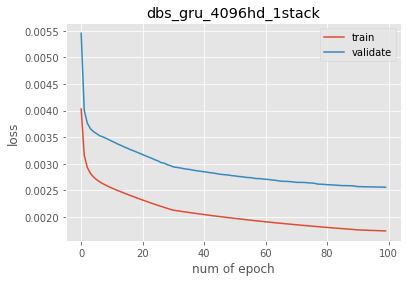

In [11]:
# temp try
total_loss, val_total_loss = train(dbs_type='gru',num_c=[256,256,256],hd=4096,num_sk=1,num_epochs=100,training_data=training_set,val_data=val_set)

In [7]:
# total_loss, val_total_loss = train(dbs_type='tcn',num_c=[512,768,1024],hd=1024,num_sk=5,num_epochs=150,training_data=training_set,val_data=val_set)
# total_loss, val_total_loss = train(dbs_type='lstm',num_c=[512,768,1024],hd=1024,num_sk=5,num_epochs=150,training_data=training_set,val_data=val_set)
# total_loss, val_total_loss = train(dbs_type='gru',num_c=[512,768,1024],hd=1024,num_sk=5,num_epochs=150,training_data=training_set,val_data=val_set)